# The impact of absorbance strenght across mulitple Fresnel numbers
>*******************************************************************************************************************************************************************

In [56]:
from init_lib import *
zs = [0.001, 0.005, 0.01, 0.05, 0.1]
energy = 15 #kev
pv = 0.1*10**(-6) # m
fresnel = [fresnel_calc(energy, z, pv) for z in zs]

spherical_setup = {}
for i in range(len(fresnel)):
    spherical_setup[str(i)] = {
        'distance_sample_detector': zs[i],
        'energy_kev': energy,
        'detector_pixel_size': pv,
        'n_x': 512,
        'n_y': 512,
    }
    
vis_dict = {
    'colorbar_size_factor': 54,
    'colorbar_location': 'bottom',
    'zoomout_location': 'top right',
    'shrink': 0.45,
    'images_per_row': 5,
    'sa_left': 0.1,
    'sa_top': 0.9,
    'sa_bottom': -0.05,
    'ttcolor': 'black',
    'stfontsize': 18,
    'ttfontsize': 18,
    'title_y': 1.0,
    'title_x': 0.5,
    'title_color': 'black',
    'sty': 0.1,
    'vmode': 'all',
    'min_max': False,
    'stx': 0.5,
    'sty': 0.03,
    'stcolor': 'black',
    'ttcolor': 'black',
    'pad': 0.00,
    'shrink': 0.8,
    'colorbar_size_factor': 40,
    'pad': 0.0,
    'vmode': 'zoom'
}
vis_dict = join_dict(vis_dict, vis_kwargs)
save_dict_to_h5(spherical_setup, '../data/bubble/setup.h5')

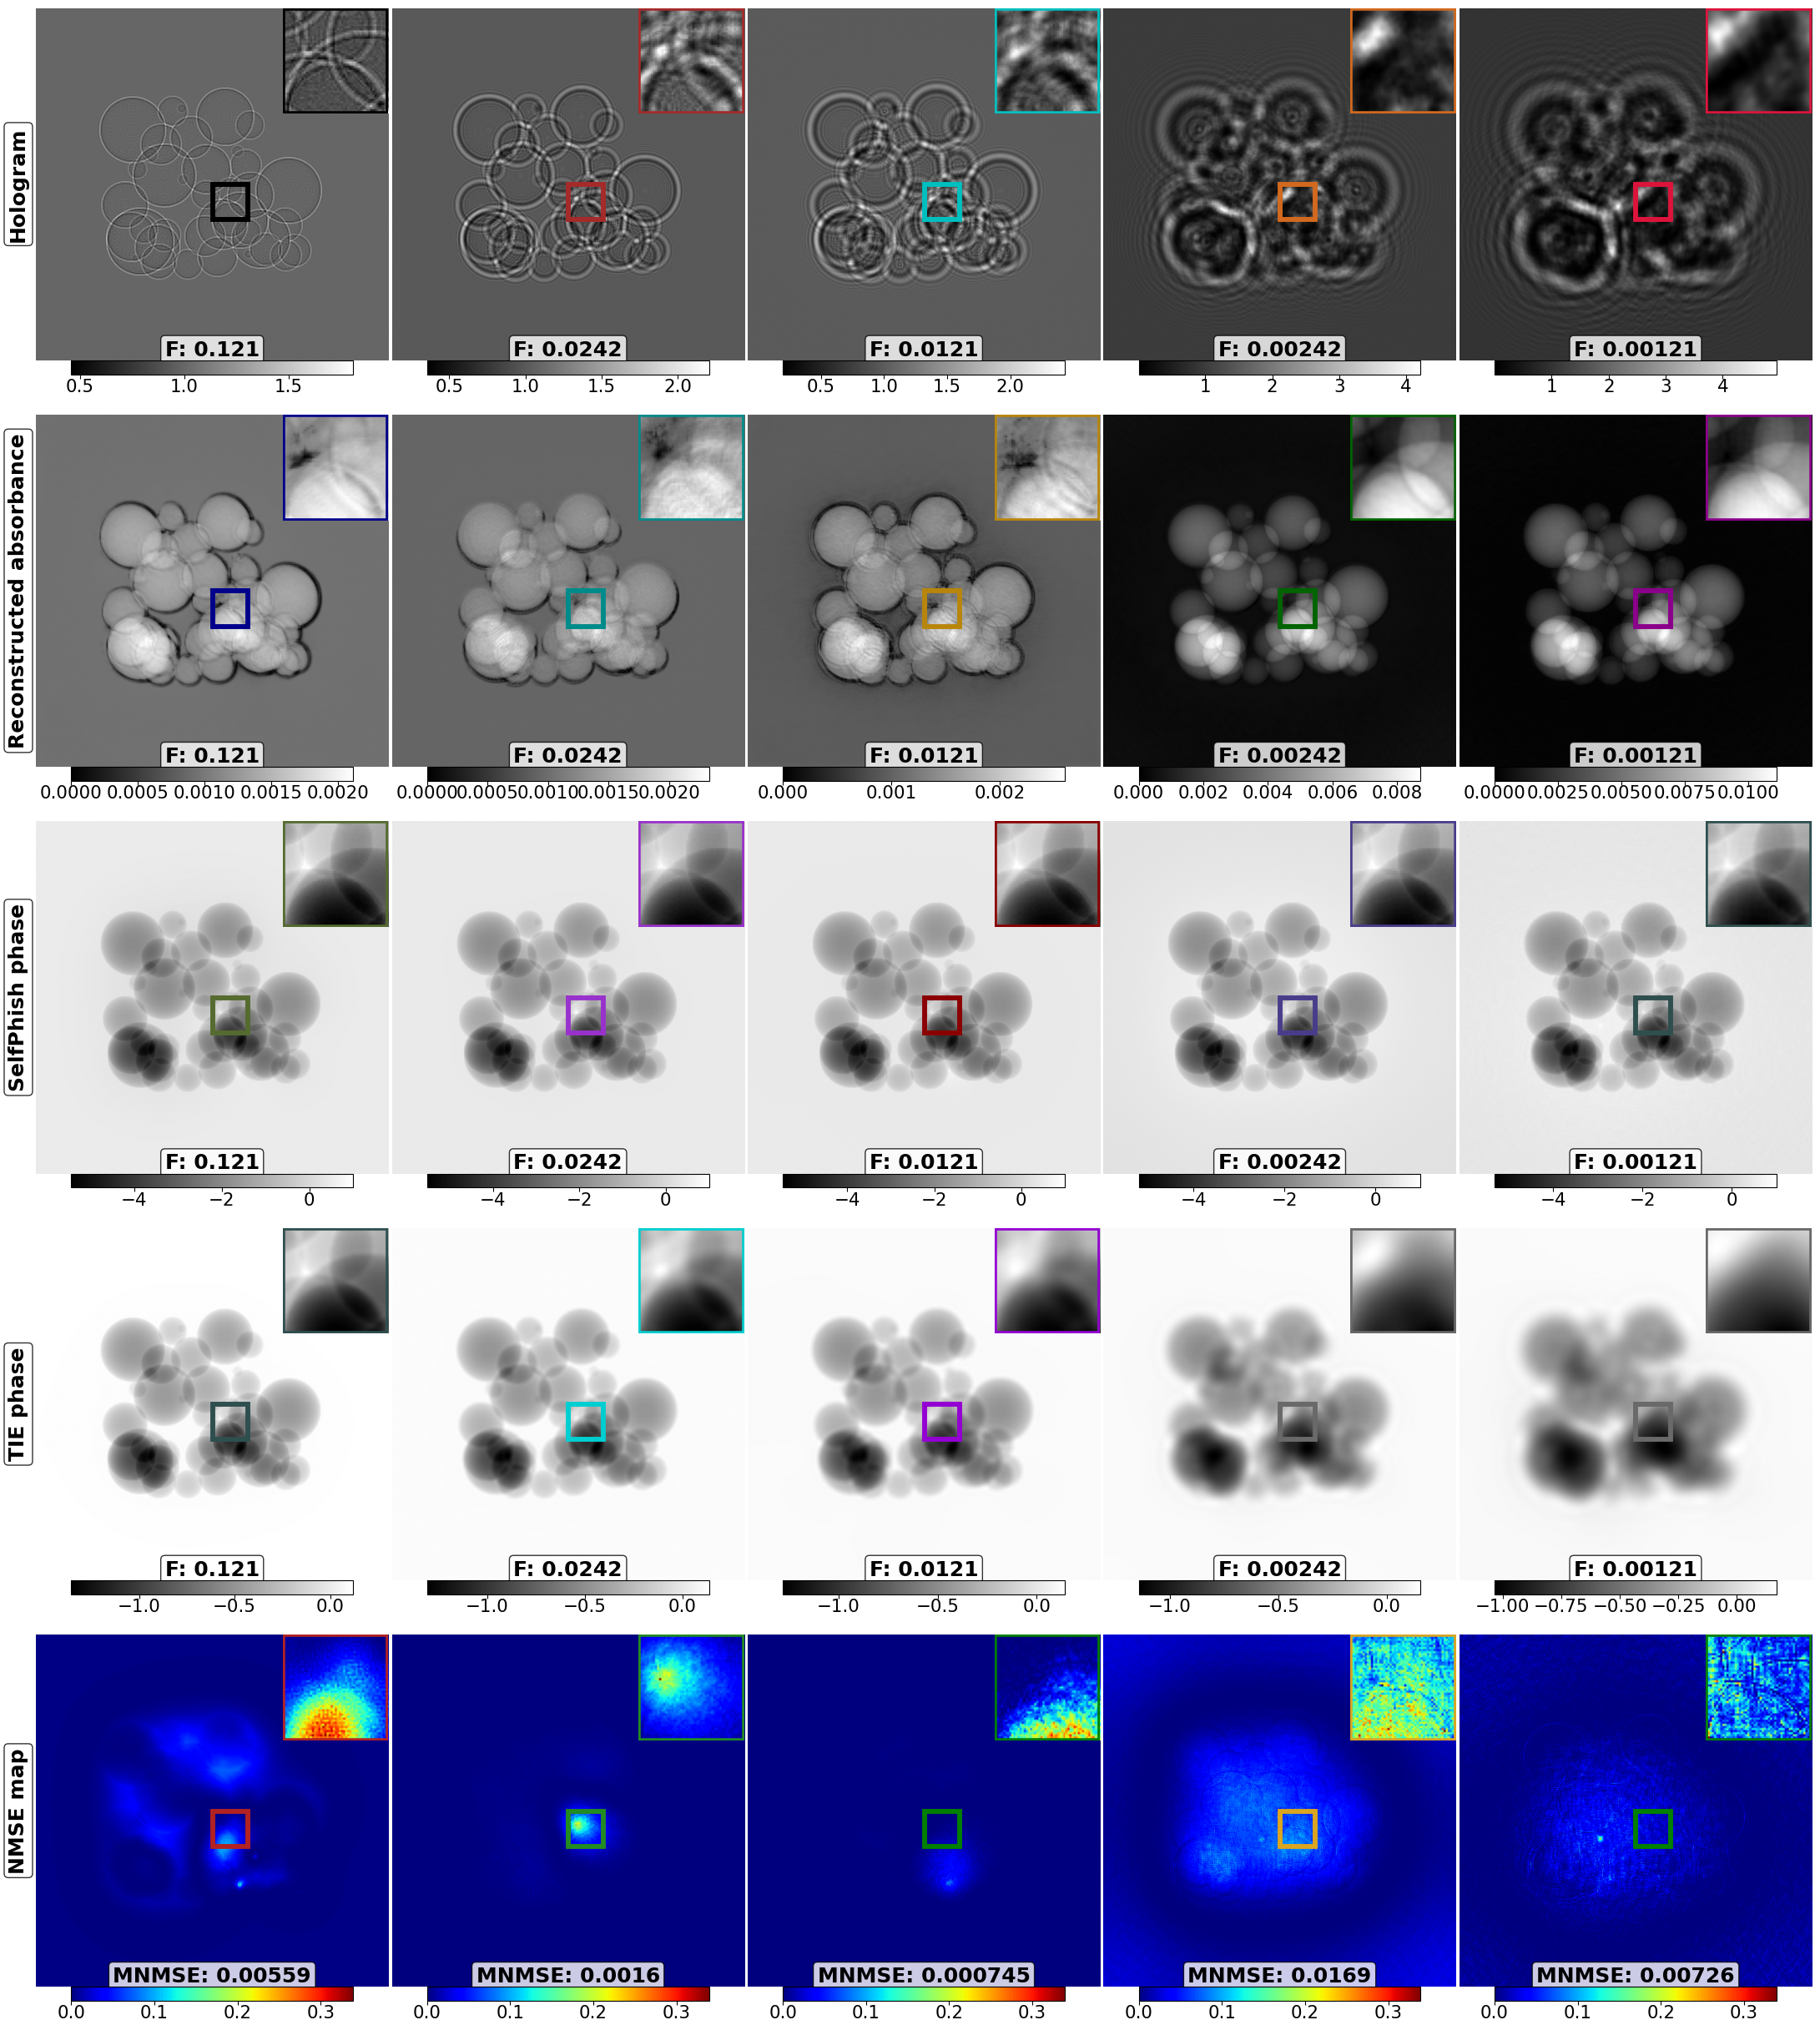

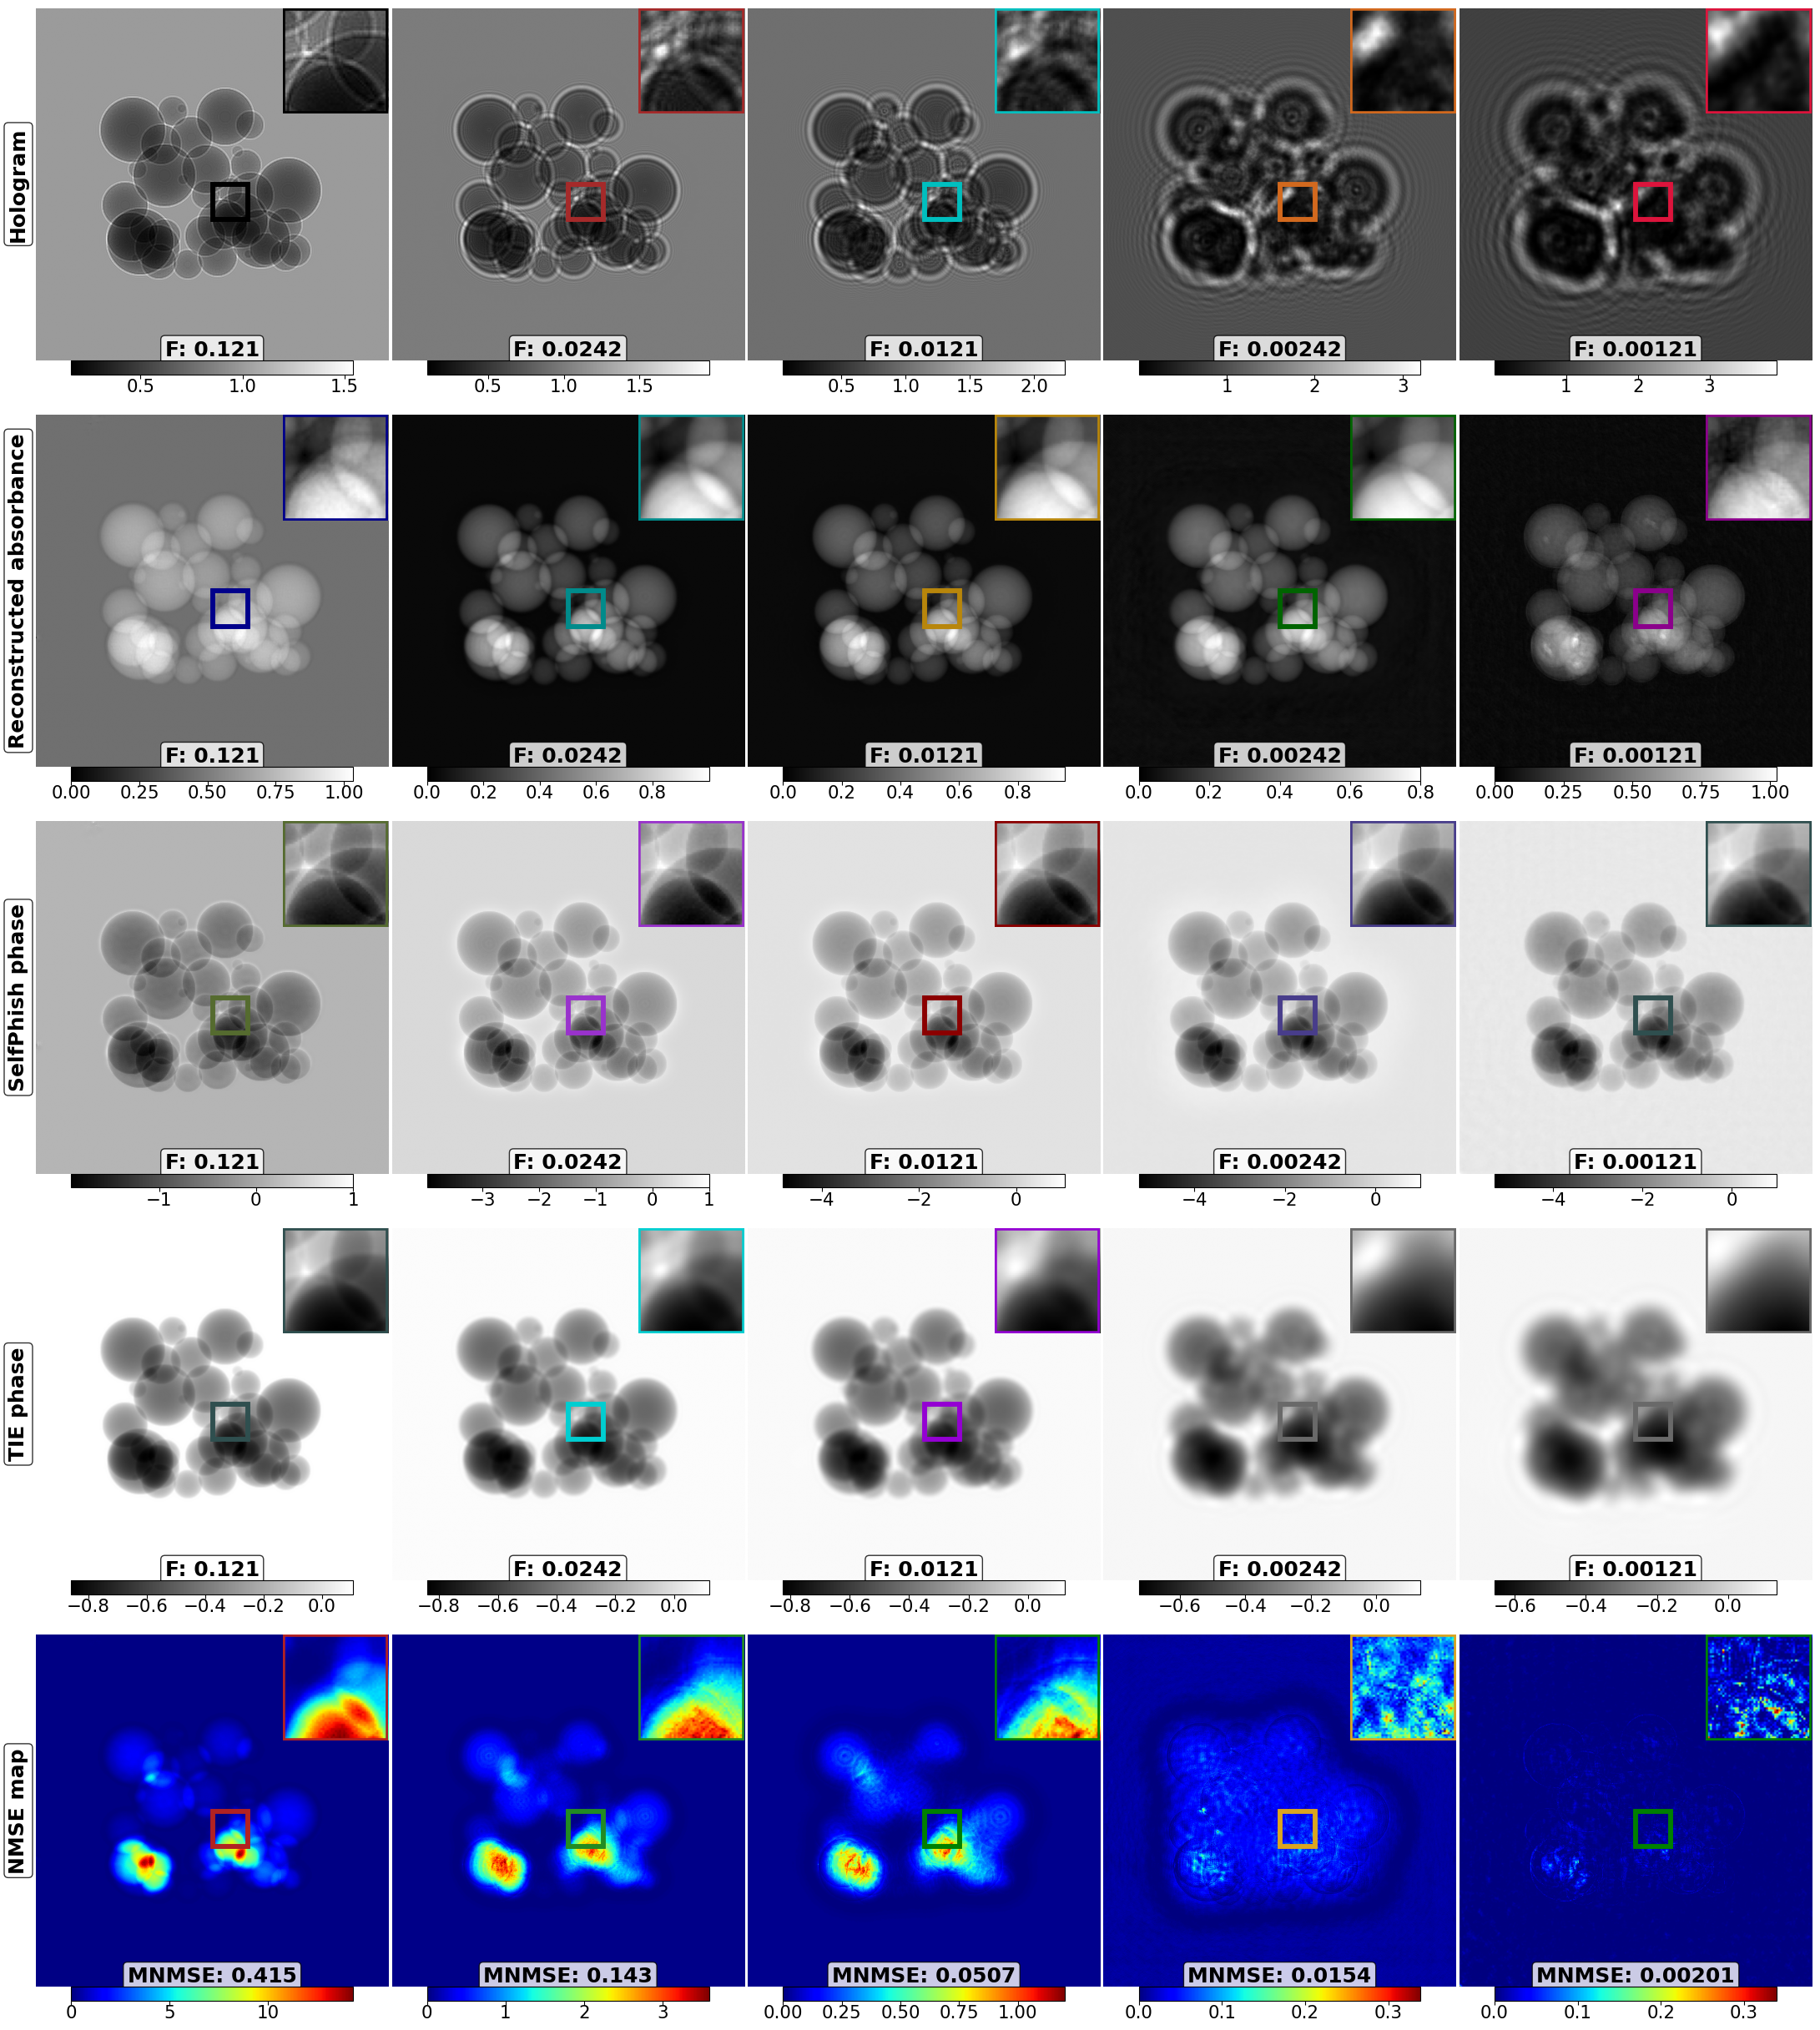

In [65]:
from skimage.metrics import structural_similarity as ssim
sim_phase = io.imread('../data/bubble/input/phase_sphere.tiff')

weak = {
    'I': [io.imread(f'../data/bubble/input/weak/hologram_sphere_e15k_z{z}mm_p100nm_abs001.tiff') for z in ['1','5','10','50','100']],
    'A': [io.imread(f"../data/bubble/output/weak/sphere_abs_e15k_z{z}mm_p100nm_abs001.tiff") for z in ['1','5','10','50','100']],
    'P': [io.imread(f"../data/bubble/output/weak/sphere_phase_e15k_z{z}mm_p100nm_abs001.tiff") for z in ['1','5','10','50','100']],
    'T': [io.imread(f'../data/bubble/output/weak/tie_{z}mm_p100nm_abs1000.tiff') for z in ['1','5','10','50','100']],
    'sim': sim_phase,
    'zs': zs,   
    'fresnel': fresnel,
    'energy': energy,
    'pv': pv,
}

strong = {
    'I': [io.imread(f'../data/bubble/input/strong/ifp_sphere_e15k_z{d}m_p01u_abs.tiff') for d in ['001','005','01','05','10']],
    'A': [io.imread(f"../data/bubble/output/strong/sphere_abs_e15_z{fr}_p1e-7.tiff") for fr in ['001','005', '01','05','10']],
    'P': [io.imread(f"../data/bubble/output/strong/sphere_phase_e15_z{fr}_p1e-7.tiff") for fr in ['001','005', '01','05','10']],
    'T': [io.imread(f'../data/bubble/output/strong/tie_{z}mm_p100nm_abs10.tiff') for z in ['1','5','10','50','100']],
    'sim': sim_phase,
    'zs': zs,   
    'fresnel': fresnel,
    'energy': energy,
    'pv': pv,
}
dicts = [weak, strong]
for d in dicts:
    ssim_maps, ssim_scores = [], []
    nmse_maps, nmse_scores = [], []
    for ph in d['P']:
        sscore, smap = ssim(d['sim'], ph, data_range=d['sim'].max() - d['sim'].min(), full=True)
        ssim_map_norm = (smap - smap.min()) / (smap.max() - smap.min())
        ssim_maps.append(ssim_map_norm)
        ssim_scores.append(np.mean(ssim_map_norm))
        nmap, nscore = calculate_error_metrics(d['sim'], ph, 'nmse', 'both')
        nscore = np.mean(nmap)
        nmse_maps.append(nmap)
        nmse_scores.append(nscore)
    d['ssim_maps'] = ssim_maps
    d['ssim_scores'] = ssim_scores
    d['nm'] = nmse_maps
    d['nmc'] = nmse_scores
    # visualize(ssim_maps, cmap = 'jet', second_title = [f"{sc:.3g}" for sc in ssim_scores])
    # visualize(nmse_maps, cmap = 'jet', second_title = [f"{sc:.3g}" for sc in nmse_scores])

    all_images = d['I'] + d['A'] + d['P'] + d['T'] + d['nm'] 
    main_title = ["Hologram", "Reconstructed absorbance", "SelfPhish phase", "TIE phase","NMSE map"]
    all_titles = []
    all_second_titles = []
    all_third_titles = []
    cmaps = []
    for i, tl in enumerate(main_title):
        for j, z in enumerate(d['zs']):
            all_titles.append(f'z={z}m')
            all_third_titles.append(f'{tl}') if j == 0 else all_third_titles.append(None)
            if tl != "NMSE map":
                all_second_titles.append(f'F: {d["fresnel"][j]:.3g}')
            else:
                all_second_titles.append(f'MNMSE: {d["nmc"][j]:.3g}')
            cmaps.append('gray' if tl != "NMSE map" else 'jet')
    all_titles = 'no_title'  # Repeat for each category
    # cmaps = ['gray' for f in d['fresnel']] * 4 + ['jet' for f in d['fresnel']]
    pop = ['title', 'second_title', 'third_title', 'cmap']
    for p in pop:
        vis_dict.pop(p, None)

    visualize(all_images, title=all_titles, second_title=all_second_titles, third_title=all_third_titles, cmap=cmaps, **vis_dict)

In [52]:
#save the weak['T'] to /data/hereon/wp/user/hailudaw/git_folders/paper_selfphish/SelfPhish/data/bubble/output/weak
[io.imsave(f'../data/bubble/output/weak/tie_{z}mm_p100nm_abs1000.tiff', ph) for z, ph in zip(['1','5','10','50','100'], weak['T'])]

[None, None, None, None, None]

# Strong absorbance

In [39]:
intensities = [io.imread(f'../data/bubble/input/strong/ifp_sphere_e15k_z{d}m_p01u_abs.tiff') for d in ['001','005','01','05','10']]
atts = [io.imread(f"../data/bubble/output/strong/sphere_abs_e15_z{fr}_p1e-7.tiff") for fr in ['001','005', '01','05','10']]
phases = [io.imread(f"../data/bubble/output/strong/sphere_phase_e15_z{fr}_p1e-7.tiff") for fr in ['001','005', '01','05','10']]
# visualize(intensities+atts+phases+TIE, images_per_row=5)
strong = {
    'I': [io.imread(f'../data/bubble/input/strong/ifp_sphere_e15k_z{d}m_p01u_abs.tiff') for d in ['001','005','01','05','10']],
    'A': [io.imread(f"../data/bubble/output/strong/sphere_abs_e15_z{fr}_p1e-7.tiff") for fr in ['001','005', '01','05','10']],
    'P': [io.imread(f"../data/bubble/output/strong/sphere_phase_e15_z{fr}_p1e-7.tiff") for fr in ['001','005', '01','05','10']],
    'sim': sim_phase,
    'zs': zs,   
    'fresnel': fresnel,
    'energy': energy,
    'pv': pv,
}

